In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from joblib import dump, load

import shap
import lime
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
import tensorflow as tf

In [4]:
file_path = '/Users/ameeshi/Desktop/fyp/data/FX_FanU_new.xlsx'
df = pd.read_excel(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])

df_ = df.drop(columns = ['CAD', 'KRONA', 'YEN', 'EURO', 'SGD', 'FRANC'])

df_['DATE'] = df_['DATE'].astype(str)
df_['DATE'] = df_['DATE'].str.split(' ').str[0]
df_.rename(columns={'DATE': 'Date'}, inplace=True)

df_.reset_index(drop = True)
# df_sg.to_csv("fx_filtered_sg.csv", index=False)

# Normalize the 'EURO' column
scaler = MinMaxScaler(feature_range=(0, 1))
df_['POUND'] = scaler.fit_transform(df_['POUND'].values.reshape(-1, 1))

df_train = df_[(df_['Date'] >= '2017-12-25') & (df_['Date'] <= '2018-12-31')]
df_test = df_[(df_['Date'] >= '2020-01-01')]

In [5]:
df_train

,Date,POUND
516,2017-12-25,0.565506
517,2017-12-26,0.565355
518,2017-12-27,0.575607
519,2017-12-28,0.587366
520,2017-12-29,0.614202
...,...,...
777,2018-12-25,0.370119
778,2018-12-26,0.356551
779,2018-12-27,0.344942
780,2018-12-28,0.360018


In [6]:
# List of currencies
currencies = ['POUND']

# Dictionary to store cumulative accuracies
cumulative_accuracies = {}

In [7]:
# Function to create lag features
def create_lag_features(df, lag=5):
    df_new = pd.DataFrame(index=df.index)
    for i in range(lag+1):
        if i == 0:
            df_new[f'{currencies}_t'] = df[currencies].values
        else:
            df_new[f'{currencies}_t-{i}'] = df[currencies].shift(i).values
    df_new.dropna(inplace=True)
    return df_new

In [8]:
lag = 5  # You can adjust this
train_df_lagged = create_lag_features(df_train, lag=lag)
test_df_lagged = create_lag_features(df_test, lag=lag)

In [9]:
train_df_lagged

,['POUND']_t,['POUND']_t-1,['POUND']_t-2,['POUND']_t-3,['POUND']_t-4,['POUND']_t-5
521,0.614202,0.614202,0.587366,0.575607,0.565355,0.565506
522,0.629881,0.614202,0.614202,0.587366,0.575607,0.565355
523,0.609830,0.629881,0.614202,0.614202,0.587366,0.575607
524,0.621438,0.609830,0.629881,0.614202,0.614202,0.587366
525,0.624906,0.621438,0.609830,0.629881,0.614202,0.614202
...,...,...,...,...,...,...
777,0.370119,0.370119,0.356852,0.345093,0.347505,0.343887
778,0.356551,0.370119,0.370119,0.356852,0.345093,0.347505
779,0.344942,0.356551,0.370119,0.370119,0.356852,0.345093
780,0.360018,0.344942,0.356551,0.370119,0.370119,0.356852


In [10]:
# Separating features and labels
X_train_fx = train_df_lagged.iloc[:, 1:].values  # All lag features
y_train_fx = train_df_lagged.iloc[:, 0].values  # Current value to predict

X_test_fx = test_df_lagged.iloc[:, 1:].values
y_test_fx = test_df_lagged.iloc[:, 0].values


# dates = create_dataset(df_sg_train)

X_train_fx = np.reshape(X_train_fx, (X_train_fx.shape[0], X_train_fx.shape[1], 1))

In [11]:
# Extract and store the 'Date' column
dates = df_train['Date']
test_dates = df_test['Date']

In [12]:
# to match the rates prediction columns with the dates
dates = dates[5:]


In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_fx.shape[1], 1)))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_fx, y_train_fx, epochs=30, batch_size=1, verbose=2) 

Epoch 1/30
261/261 - 1s - loss: 0.0108 - 676ms/epoch - 3ms/step
Epoch 2/30
261/261 - 0s - loss: 0.0013 - 156ms/epoch - 599us/step
Epoch 3/30
261/261 - 0s - loss: 0.0012 - 164ms/epoch - 627us/step
Epoch 4/30
261/261 - 0s - loss: 0.0012 - 152ms/epoch - 582us/step
Epoch 5/30
261/261 - 0s - loss: 0.0014 - 274ms/epoch - 1ms/step
Epoch 6/30
261/261 - 0s - loss: 0.0013 - 163ms/epoch - 624us/step
Epoch 7/30
261/261 - 0s - loss: 0.0011 - 155ms/epoch - 593us/step
Epoch 8/30
261/261 - 0s - loss: 0.0014 - 153ms/epoch - 588us/step
Epoch 9/30
261/261 - 0s - loss: 0.0012 - 210ms/epoch - 804us/step
Epoch 10/30
261/261 - 0s - loss: 0.0013 - 206ms/epoch - 789us/step
Epoch 11/30
261/261 - 0s - loss: 0.0011 - 161ms/epoch - 615us/step
Epoch 12/30
261/261 - 0s - loss: 0.0010 - 161ms/epoch - 617us/step
Epoch 13/30
261/261 - 0s - loss: 0.0012 - 156ms/epoch - 597us/step
Epoch 14/30
261/261 - 0s - loss: 0.0012 - 178ms/epoch - 683us/step
Epoch 15/30
261/261 - 0s - loss: 0.0011 - 165ms/epoch - 634us/step
Epoch 16

In [14]:
# Predicting for all dates in the dataset 
y_pred_train = model.predict(X_train_fx)

9/9 [==============================] - 0s 624us/step


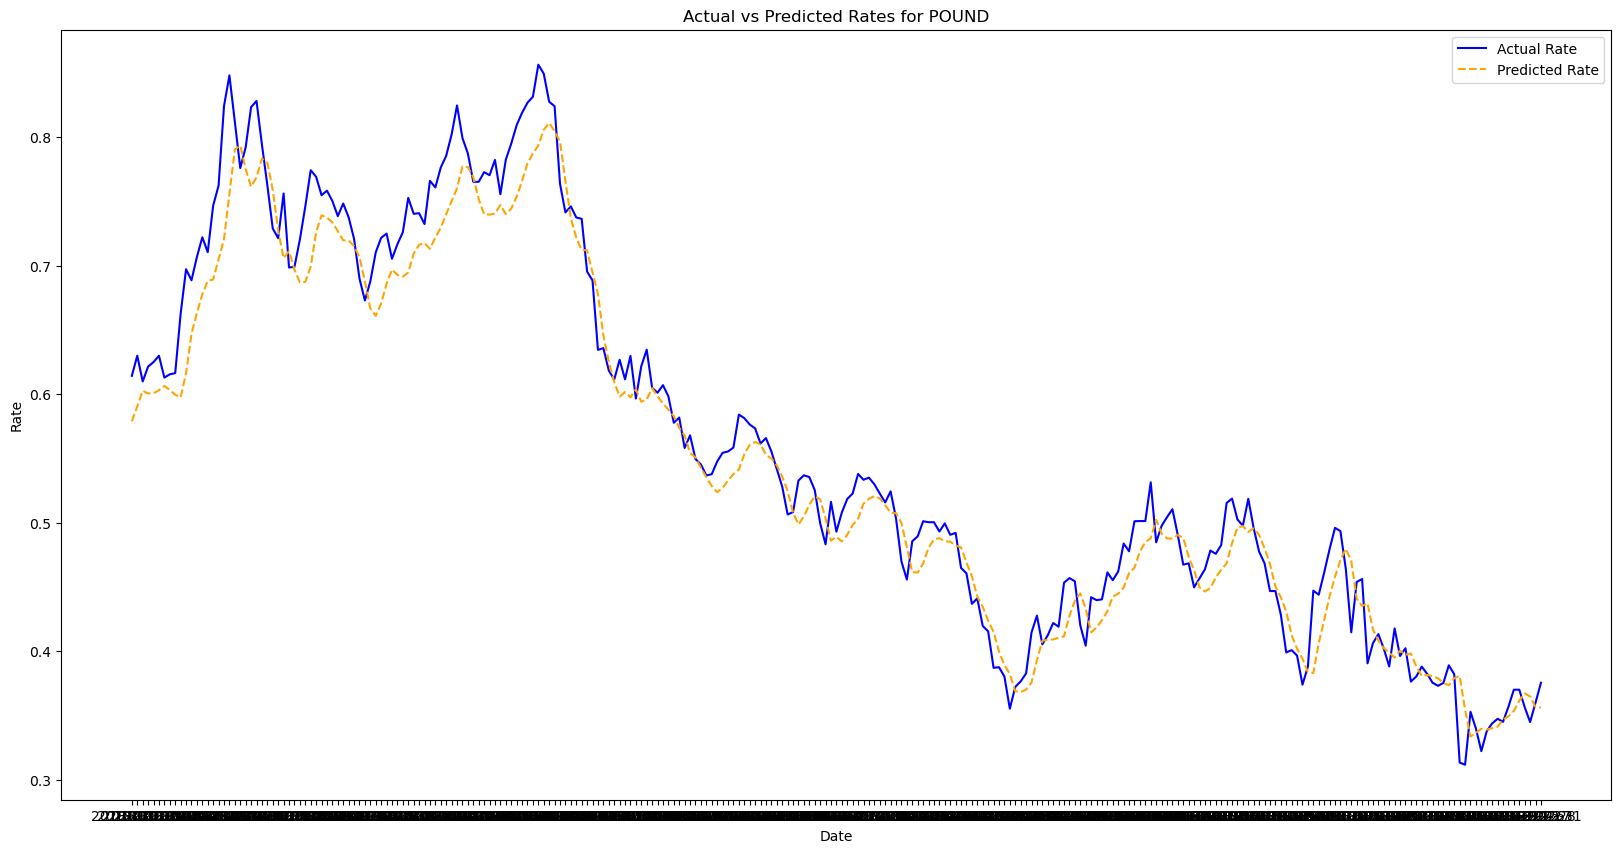

In [15]:
# for plot
plt.figure(figsize=(20,10))
plt.plot(dates, y_train_fx, label='Actual Rate', color='blue')
plt.plot(dates, y_pred_train, label='Predicted Rate', linestyle='--', color='orange')
plt.title(f'Actual vs Predicted Rates for POUND')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

In [16]:
# for test dataset
X_test_fx = np.reshape(X_test_fx, (X_test_fx.shape[0], X_test_fx.shape[1], 1))
y_pred_test = model.predict(X_test_fx)


18/18 [==============================] - 0s 622us/step


In [17]:


test_error_mse = mean_squared_error(y_test_fx, y_pred_test)
print(f"Test MSE: {test_error_mse}")

test_error_rmse = np.sqrt(test_error_mse)
print(f"Test RMSE: { test_error_rmse}")

test_r2 = r2_score(y_test_fx, y_pred_test)
print(f"Test r2 score: {test_r2}")

Test MSE: 0.001070530711995281
Test RMSE: 0.03271896563150004
Test r2 score: 0.9612178565301263


In [18]:
# adjusting test dates to match the prediction rate correctly
adjusted_test_dates = test_dates[lag:] 
adjusted_test_dates = adjusted_test_dates[:len(y_pred_test)]

In [19]:
actual_with_dates = {date: actual for date, actual in zip(adjusted_test_dates, y_test_fx)}

# Printing the first few items to verify
for date, actual in list(actual_with_dates.items())[:5]:
    print(f"Date: {date}, Actual: {actual}")

Date: 2020-01-08, Actual: 0.4849992461932766
Date: 2020-01-09, Actual: 0.46962158902457407
Date: 2020-01-10, Actual: 0.47339062264435405
Date: 2020-01-13, Actual: 0.44851500075380724
Date: 2020-01-14, Actual: 0.4580129654756524


In [20]:
# Creating a dictionary to store predictions with their corresponding date
predictions_with_dates = {date: prediction for date, prediction in zip(adjusted_test_dates, y_pred_test)}

# Printing the first few items to verify
for date, prediction in list(predictions_with_dates.items())[:5]:
    print(f"Date: {date}, Prediction: {prediction}")

Date: 2020-01-08, Prediction: [0.48009476]
Date: 2020-01-09, Prediction: [0.47731155]
Date: 2020-01-10, Prediction: [0.47002235]
Date: 2020-01-13, Prediction: [0.46359104]
Date: 2020-01-14, Prediction: [0.4518014]


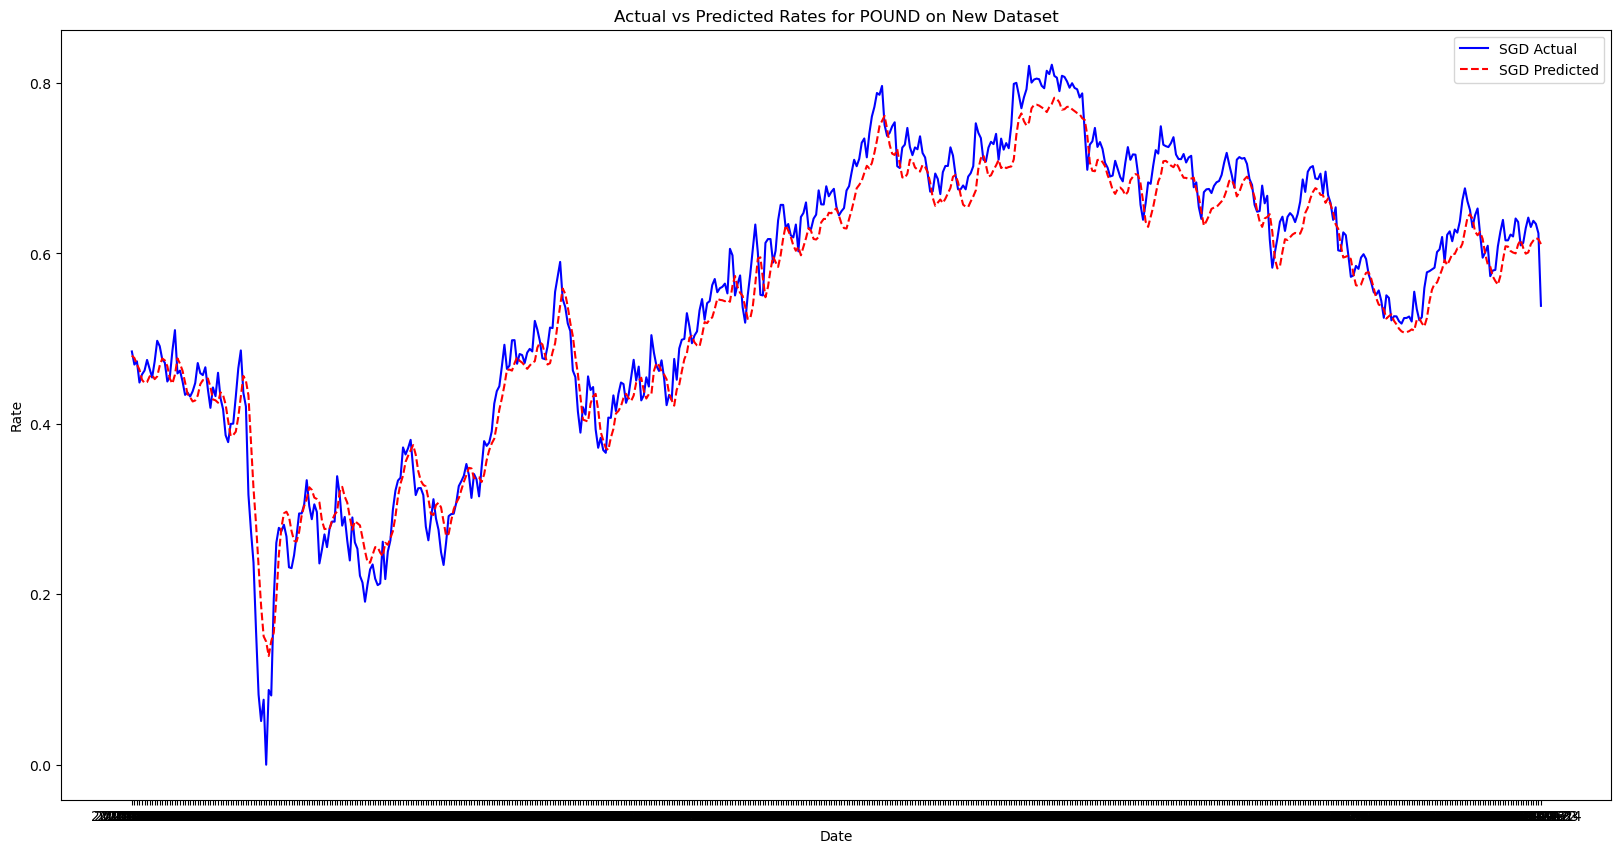

In [21]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(adjusted_test_dates, y_test_fx, label=f'SGD Actual', linestyle='-', color='blue')
plt.plot(adjusted_test_dates, y_pred_test, label=f'SGD Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates for POUND on New Dataset')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()

In [22]:
dtypes = {'RegionName': str, 'RegionCode': str}
file_path_oxford = '/Users/ameeshi/Desktop/fyp/OxCGRT_nat_latest.xlsx'  # Update this path
df_oxford = pd.read_excel(file_path_oxford, dtype=dtypes)



In [23]:
df_oxford.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
interested_country = ['United Kingdom']
# Filter for Singapore
df_oxford_ = df_oxford[df_oxford['CountryName'].isin(interested_country)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

df_oxford_['Date'] = df_oxford_['Date'].apply(convert_date)

columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]


# Select specified policy columns (N, R, T, etc. are placeholders for actual column names)
# coln_to_select = ['CURRENCY','CountryName','Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
#     'C4_Restrictions on gatherings', 'C5_Close public transport', 
#     'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
#     'C8_International travel controls', 'H1_Public information campaigns',
#     'H2_Testing policy', 'H3_Contact tracing', 'StringencyIndex', 'GovernmentResponseIndex']

# oxcg_filtered= df_oxford_sg[coln_to_select]

# Drop unwanted columns
oxcg_filtered = df_oxford_.drop(columns=columns_to_drop)



/var/folders/pv/j2j3lxvn5y76w14wslmbh_gc0000gn/T/ipykernel_35666/1825114799.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oxford_['Date'] = df_oxford_['Date'].apply(convert_date)


In [25]:

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

In [26]:
country = {'POUND': ['United Kingdom', 'POUND']}

oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

In [27]:
# making a new dataframe for predicted rates and the dates for merging 
rates_df = pd.DataFrame(list(predictions_with_dates.items()), columns = ['Date', 'PredRate'])
actualrate_df = pd.DataFrame(list(actual_with_dates.items()), columns = ['Date', 'ActualRate'])

merged_df = pd.merge(oxcg_filtered, rates_df, on='Date', how='inner')

In [28]:
merged_df = pd.merge(merged_df, actualrate_df, on = 'Date', how = 'inner')

In [29]:
merged_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate,ActualRate
0,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2020-01-08,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,0.00,0.00,0.0,0.0,[0.48009476],0.484999
1,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2020-01-09,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,0.00,0.00,0.0,0.0,[0.47731155],0.469622
2,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2020-01-10,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,0.00,0.00,0.0,0.0,[0.47002235],0.473391
3,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2020-01-13,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,0.00,0.00,0.0,0.0,[0.46359104],0.448515
4,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2020-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,0.00,0.00,0.0,0.0,[0.4518014],0.458013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,0.0,...,5.0,2.0,NaN,29.06,40.04,42.19,25.0,47147.0,[0.61087847],0.631087
553,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,0.0,...,5.0,2.0,NaN,29.06,40.04,42.19,25.0,38139.0,[0.61515945],0.638324
554,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,0.0,...,5.0,2.0,NaN,29.06,40.04,42.19,25.0,40876.0,[0.61809117],0.634705
555,United Kingdom,GBR,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,0.0,...,5.0,2.0,NaN,29.05,40.04,42.19,25.0,39235.0,[0.6167281],0.623700


In [30]:
# train data
oxcg_filtered_train = merged_df[(merged_df['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

# test data
oxcg_filtered_test = merged_df[(merged_df['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

In [31]:
oxcg_test_dates = oxcg_filtered_test['Date']

In [32]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features_to_select = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people']

# fx_rate = predictions_with_dates.get("Prediction")

In [33]:
X_train_oxcg = oxcg_filtered_train[features_to_select]
y_train_oxcg = oxcg_filtered_train['PredRate']

X_test_oxcg = oxcg_filtered_test[features_to_select]
y_test_oxcg = oxcg_filtered_test["PredRate"]
y_test_act = oxcg_filtered_test['ActualRate']

In [34]:
X_train_oxcg = np.reshape(X_train_oxcg, (X_train_oxcg.shape[0], X_train_oxcg.shape[1], 1))

X_train_oxcg = X_train_oxcg.astype('float32')
y_train_oxcg = y_train_oxcg.astype('float32')

In [35]:
X_train_oxcg_tf = tf.convert_to_tensor(X_train_oxcg, dtype=tf.float32)
y_train_oxcg_tf = tf.convert_to_tensor(y_train_oxcg, dtype=tf.float32)

In [36]:
# Build the LSTM model
oxcg_model = Sequential()
oxcg_model.add(LSTM(50, input_shape=(X_train_oxcg_tf.shape[1], 1)))
oxcg_model.add(Dense(1))



In [37]:
# Compile the model
oxcg_model.compile(loss='mean_squared_error', optimizer='adam')



In [38]:
# Train the model
oxcg_model.fit(X_train_oxcg_tf, y_train_oxcg_tf, epochs=30, batch_size=1, verbose=2) 

Epoch 1/30
257/257 - 1s - loss: 0.0139 - 874ms/epoch - 3ms/step
Epoch 2/30
257/257 - 0s - loss: 0.0059 - 329ms/epoch - 1ms/step
Epoch 3/30
257/257 - 0s - loss: 0.0053 - 353ms/epoch - 1ms/step
Epoch 4/30
257/257 - 0s - loss: 0.0037 - 439ms/epoch - 2ms/step
Epoch 5/30
257/257 - 0s - loss: 0.0039 - 434ms/epoch - 2ms/step
Epoch 6/30
257/257 - 0s - loss: 0.0038 - 358ms/epoch - 1ms/step
Epoch 7/30
257/257 - 0s - loss: 0.0039 - 357ms/epoch - 1ms/step
Epoch 8/30
257/257 - 0s - loss: 0.0039 - 398ms/epoch - 2ms/step
Epoch 9/30
257/257 - 0s - loss: 0.0050 - 353ms/epoch - 1ms/step
Epoch 10/30
257/257 - 0s - loss: 0.0034 - 350ms/epoch - 1ms/step
Epoch 11/30
257/257 - 0s - loss: 0.0047 - 361ms/epoch - 1ms/step
Epoch 12/30
257/257 - 0s - loss: 0.0033 - 405ms/epoch - 2ms/step
Epoch 13/30
257/257 - 0s - loss: 0.0036 - 397ms/epoch - 2ms/step
Epoch 14/30
257/257 - 0s - loss: 0.0035 - 352ms/epoch - 1ms/step
Epoch 15/30
257/257 - 0s - loss: 0.0036 - 414ms/epoch - 2ms/step
Epoch 16/30
257/257 - 0s - loss: 0

In [39]:
X_test_oxcg_tf = tf.convert_to_tensor(X_test_oxcg, dtype=tf.float32)
y_test_oxcg_tf = tf.convert_to_tensor(y_test_oxcg, dtype=tf.float32)

In [40]:
X_test_oxcg_tf = np.reshape(X_test_oxcg_tf, (X_test_oxcg_tf.shape[0], X_test_oxcg_tf.shape[1], 1))

In [41]:
# predicting revised rate 
y_pred = oxcg_model.predict(X_test_oxcg)


10/10 [==============================] - 0s 1ms/step


In [42]:
mae = mean_absolute_error(y_test_act, y_test_oxcg)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test_act, y_test_oxcg)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(mse)
print(f" RMSE: { rmse}")

r2 = r2_score(y_test_act, y_test_oxcg)
print(f"r2 score: {r2}")

Mean Absolute Error: 0.024969252145879417
Mean Squared Error: 0.000877354042727699
 RMSE: 0.029620162773484195
r2 score: 0.820936340124241


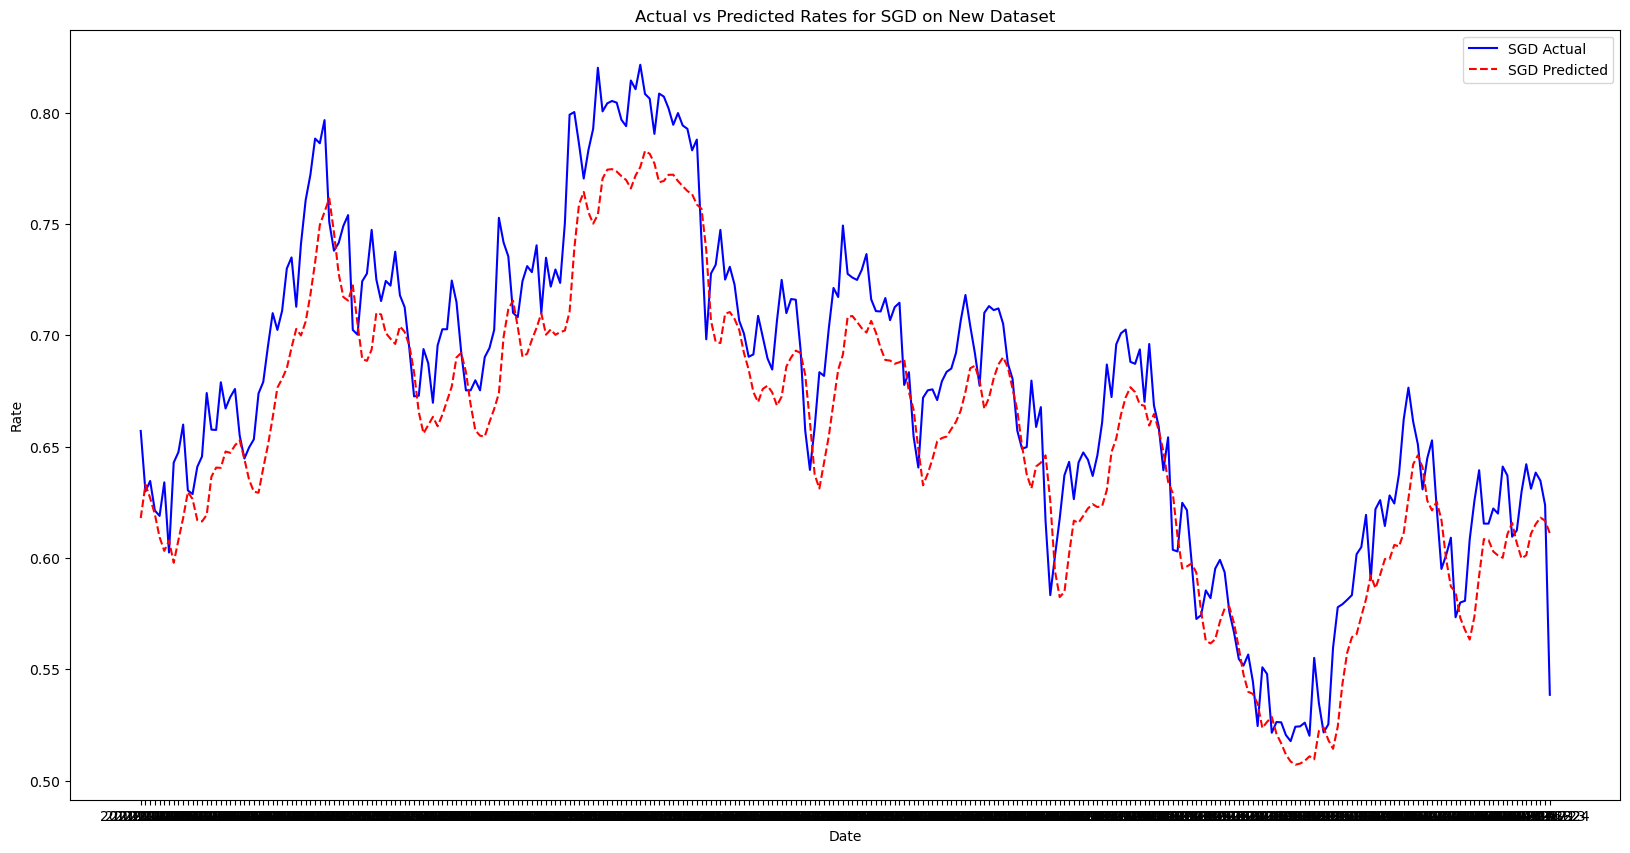

In [43]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(oxcg_test_dates, y_test_act, label=f'SGD Actual', linestyle='-', color='blue')
plt.plot(oxcg_test_dates, y_test_oxcg, label=f'SGD Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates for SGD on New Dataset')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()